In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('nba_game_df.csv')
df = df.sort_values(by=['date']).reset_index(drop=True)
pd.set_option('display.max_columns', None)
df.head(6)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_3P%_basic_max,Team_A_3P%_basic_totals,Team_A_3PA_basic_max,Team_A_3PA_basic_totals,Team_A_3PAr_advanced_max,Team_A_3PAr_advanced_totals,Team_A_3P_basic_max,Team_A_3P_basic_totals,Team_A_AST%_advanced_max,Team_A_AST%_advanced_totals,Team_A_AST_basic_max,Team_A_AST_basic_totals,Team_A_BLK%_advanced_max,Team_A_BLK%_advanced_totals,Team_A_BLK_basic_max,Team_A_BLK_basic_totals,Team_A_DRB%_advanced_max,Team_A_DRB%_advanced_totals,Team_A_DRB_basic_max,Team_A_DRB_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_max,Team_A_FG%_basic_totals,Team_A_FGA_basic_max,Team_A_FGA_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_FT%_basic_max,Team_A_FT%_basic_totals,Team_A_FTA_basic_max,Team_A_FTA_basic_totals,Team_A_FT_basic_max,Team_A_FT_basic_totals,Team_A_FTr_advanced_max,Team_A_FTr_advanced_totals,Team_A_GmSc_basic_max,Team_A_MP_advanced_totals,Team_A_ORB%_advanced_max,Team_A_ORB%_advanced_totals,Team_A_ORB_basic_max,Team_A_ORB_basic_totals,Team_A_ORtg_advanced_max,Team_A_ORtg_advanced_totals,Team_A_PF_basic_max,Team_A_PF_basic_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q2,Team_A_Q3,Team_A_Q4,Team_A_STL%_advanced_max,Team_A_STL%_advanced_totals,Team_A_STL_basic_max,Team_A_STL_basic_totals,Team_A_TOV%_advanced_max,Team_A_TOV%_advanced_totals,Team_A_TOV_basic_max,Team_A_TOV_basic_totals,Team_A_TRB%_advanced_max,Team_A_TRB%_advanced_totals,Team_A_TRB_basic_max,Team_A_TRB_basic_totals,Team_A_TS%_advanced_max,Team_A_TS%_advanced_totals,Team_A_USG%_advanced_max,Team_A_eFG%_advanced_max,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3P%_basic_max,Team_B_3P%_basic_totals,Team_B_3PA_basic_max,Team_B_3PA_basic_totals,Team_B_3PAr_advanced_max,Team_B_3PAr_advanced_totals,Team_B_3P_basic_max,Team_B_3P_basic_totals,Team_B_AST%_advanced_max,Team_B_AST%_advanced_totals,Team_B_AST_basic_max,Team_B_AST_basic_totals,Team_B_BLK%_advanced_max,Team_B_BLK%_advanced_totals,Team_B_BLK_basic_max,Team_B_BLK_basic_totals,Team_B_DRB%_advanced_max,Team_B_DRB_basic_max,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_max,Team_B_FG%_basic_totals,Team_B_FGA_basic_max,Team_B_FGA_basic_totals,Team_B_FG_basic_max,Team_B_FG_basic_totals,Team_B_FT%_basic_max,Team_B_FT%_basic_totals,Team_B_FTA_basic_max,Team_B_FTA_basic_totals,Team_B_FT_basic_max,Team_B_FT_basic_totals,Team_B_FTr_advanced_max,Team_B_FTr_advanced_totals,Team_B_GmSc_basic_max,Team_B_ORB%_advanced_max,Team_B_ORB_basic_max,Team_B_ORB_basic_totals,Team_B_ORtg_advanced_max,Team_B_ORtg_advanced_totals,Team_B_PF_basic_max,Team_B_PF_basic_totals,Team_B_PTS_basic_max,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_Q2,Team_B_Q3,Team_B_Q4,Team_B_STL%_advanced_max,Team_B_STL%_advanced_totals,Team_B_STL_basic_max,Team_B_STL_basic_totals,Team_B_TOV%_advanced_max,Team_B_TOV%_advanced_totals,Team_B_TOV_basic_max,Team_B_TOV_basic_totals,Team_B_TRB%_advanced_max,Team_B_TRB_basic_max,Team_B_TRB_basic_totals,Team_B_TS%_advanced_max,Team_B_TS%_advanced_totals,Team_B_USG%_advanced_max,Team_B_eFG%_advanced_max,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game
0,1,5,BOS_vs_CLE,2009-10-27,11.0,1.000,0.474,6.0,19.0,1.000,0.264,3.0,9.0,52.7,62.5,10.0,20.0,8.2,15.1,3.0,8.0,33.3,84.2,10.0,32.0,107.0,99.3,0.6,0.444,16.0,72.0,6.0,32.0,1.000,0.846,10.0,26.0,9.0,22.0,4.000,0.361,18.0,240.0,13.6,18.8,3.0,6.0,125.0,106.0,5.0,27.0,23.0,95.0,21,30,21,23,4.7,10.0,3.0,9.0,28.7,16.1,3.0,16.0,20.7,54.3,11.0,38.0,0.725,0.569,25.2,0.700,0.507,3.0,0.667,0.353,9.0,17.0,0.409,0.243,4.0,6.0,52.9,58.6,8.0,17.0,8.1,17.0,4.0,9.0,52.1,10.0,26.0,115.0,106.6,0.545,0.414,22.0,70.0,12.0,29.0,1.000,0.781,13.0,32.0,10.0,25.0,1.000,0.457,31.2,19.2,5.0,6.0,121.0,99.9,5.0,22.0,38.0,89.0,28,17,20,24,8.7,7.9,2.0,7.0,25.0,14.3,5.0,14.0,23.8,10.0,32.0,0.685,0.529,36.0,0.636,0.457,1,0,0.0,0
1,10,24,HOU_vs_POR,2009-10-27,8.0,1.000,0.278,6.0,18.0,0.500,0.222,2.0,5.0,58.7,6

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [4]:
df = df.drop(columns=['date', 'matchup_id'])
train_size = int(0.7 * len(df))  
val_size = int(0.15 * len(df))   
test_size = len(df) - train_size - val_size  

y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])
x_train = df.iloc[:train_size]

x_val = df.iloc[train_size:train_size+val_size]
x_test = df.iloc[train_size+val_size:]
y_train = y.iloc[:train_size]
y_train = y_train.to_numpy().reshape(-1,1)
y_val = y.iloc[train_size:train_size+val_size]
y_val = y_val.to_numpy().reshape(-1,1)
y_test = y.iloc[train_size+val_size:]
y_test = y_test.to_numpy().reshape(-1,1)
x_train.shape

(13108, 141)

In [5]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B'])
normalize_cols = [col for col in all_columns if col not in exclude_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

x_train[:, normalize_indices] = (x_train[:, normalize_indices] - mean) / std
x_val[:, normalize_indices] = (x_val[:, normalize_indices] - mean) / std
x_test[:, normalize_indices] = (x_test[:, normalize_indices] - mean) / std

In [6]:
num_features = x_train.shape[1]
w = np.random.normal(0, 0.01, size=(num_features, 1))
b = 0
#z = x_train @ w + b
#y_pred = sigmoid(z)

In [7]:
#print(y_pred[:5])         # Should show values between 0 and 1
#print(y_pred.shape)       # Should be (m_train, 1)

In [8]:
def compute_cost(x, y, w, b):
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    loss = - (1/m) * (y.T @ np.log(y_pred) + (1 - y).T @ np.log(1 - y_pred))
    return loss.item()

In [9]:
def compute_gradients(x, y, w, b): 
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    dj_dw = (1/m) * x.T @ (y_pred - y) 
    dj_db = (1/m) * np.sum(y_pred - y)
    return dj_dw, dj_db

In [10]:
learning_rate = 0.01
num_epochs = 100
train_cost_history = []
val_cost_history = []

for epoch in range(num_epochs):
    dj_dw, dj_db = compute_gradients(x_train, y_train, w, b)
    
    #print(f"Epoch {epoch+1}")
    #print(f"  Mean dj_dw: {np.mean(dj_dw):.6f}, dj_db: {dj_db:.6f}")
    #print(f"  Mean weight before update: {np.mean(w):.6f}")

    w = w - (learning_rate * dj_dw)
    b = b - (learning_rate * dj_db)
    
    #print(f"  Mean weight after update: {np.mean(w):.6f}")
    #print(f"  Training Cost: {train_cost:.6f}, Validation Cost: {val_cost:.6f}")
    
    train_cost = compute_cost(x_train, y_train, w, b)
    train_cost_history.append(train_cost) 
    val_cost = compute_cost(x_val, y_val, w, b)
    val_cost_history.append(val_cost) 
    print(f"Epoch {epoch+1}/{num_epochs}, Training Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")


Epoch 1/100, Training Cost: 0.6958, Validation Cost: 0.6963
Epoch 2/100, Training Cost: 0.6948, Validation Cost: 0.6950
Epoch 3/100, Training Cost: 0.6940, Validation Cost: 0.6945
Epoch 4/100, Training Cost: 0.6932, Validation Cost: 0.6938
Epoch 5/100, Training Cost: 0.6925, Validation Cost: 0.6933
Epoch 6/100, Training Cost: 0.6918, Validation Cost: 0.6927
Epoch 7/100, Training Cost: 0.6911, Validation Cost: 0.6922
Epoch 8/100, Training Cost: 0.6905, Validation Cost: 0.6918
Epoch 9/100, Training Cost: 0.6899, Validation Cost: 0.6913
Epoch 10/100, Training Cost: 0.6894, Validation Cost: 0.6909
Epoch 11/100, Training Cost: 0.6889, Validation Cost: 0.6905
Epoch 12/100, Training Cost: 0.6884, Validation Cost: 0.6901
Epoch 13/100, Training Cost: 0.6879, Validation Cost: 0.6898
Epoch 14/100, Training Cost: 0.6874, Validation Cost: 0.6895
Epoch 15/100, Training Cost: 0.6870, Validation Cost: 0.6892
Epoch 16/100, Training Cost: 0.6866, Validation Cost: 0.6889
Epoch 17/100, Training Cost: 0.68

In [11]:
z_val = x_val @ w + b
y_val_probs = sigmoid(z_val)
y_val_pred = (y_val_probs >= 0.5).astype(int)
accuracy = np.mean(y_val_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.3f}%")

Validation Accuracy: 55.306%


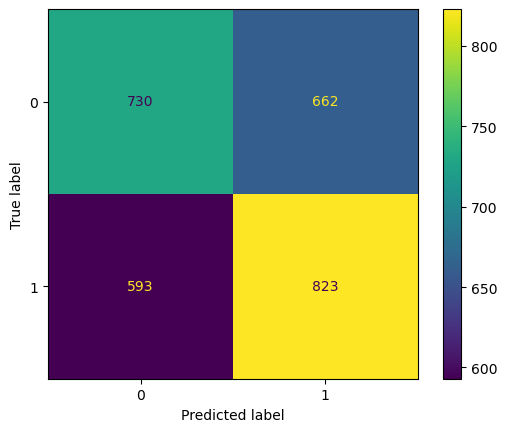

In [13]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()

In [14]:
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
probs = sigmoid(x_val @ w + b)
auc = roc_auc_score(y_val, probs)
print("AUC:", auc)

TPR: 0.5812
FPR: 0.476
TNR: 0.524
FNR: 0.419
AUC: 0.5753204347684914


In [15]:
#p = 0.45
#TPR: 0.7830
#FPR: 0.667
#TNR: 0.333
#FNR: 0.217
#AUC: 0.5759889392426454
#Validation Accuracy: 55.993%

#p = 0.5 
#TPR: 0.5812
#FPR: 0.476
#TNR: 0.524
#FNR: 0.419
#AUC: 0.5753204347684914
#Validation Accuracy: 55.306%